In [1]:
# http://stackoverflow.com/questions/7718034/maximum-likelihood-estimate-pseudocode
# http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/
# Our goal: estimate the posterior of the mean \mu (assuming we know the standard deviation to be 1), 
# using N points from a normal centered around zero

import numpy as np
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

# Generate fake data set (Gaussian centered at zero)
n_data = 500 # Try also 5000: what happens?
burnin = 100
np.random.seed(100100) # For reproducibility
data = np.random.randn(n_data)

#Parameters for the MCMC-MH method
prop_width = 0.1 # Width (sigma) of proposed step from current step
chain = [0.5]     # Starting value of chain
rejected = 0     # Track number of rejected proposals to compute rejection rate

def gaussian(x, amplitude, mean, sigma):
    return amplitude*(1/(sigma*(np.sqrt(2*np.pi))))*(np.exp(-((x-mean)**2)/((2*sigma)**2)))

def get_bin_centers(values):
    return [(values[i]+values[i+1])*0.5 for i in range(len(values)-1)]

In [2]:
# Build the chain
while len(chain) < 1000:
    
    current_mu = chain[-1]
    proposed_mu = norm(current_mu, prop_width).rvs() # propose step

    # Likelihoods
    current_lh = norm(current_mu, 1).pdf(data).prod()
    proposed_lh = norm(proposed_mu, 1).pdf(data).prod()

    # Priors
    current_prior = norm(0, 1).pdf(current_mu)
    proposed_prior = norm(0, 1).pdf(proposed_mu)

    # Nominator of Bayes formula
    current_p = current_lh * current_prior
    proposed_p = proposed_lh * proposed_prior
    
    # Acceptance factor: ratio of posteriors
    acceptance_factor = proposed_p / current_p
    accept = np.random.rand() < acceptance_factor

    if accept:
        chain.append(proposed_mu) # Add accepted proposal to chain
    else:
        rejected+=1
        chain.append(current_mu) # Note: store a value *anyway*!
    
print("Rejection rate: {:.2f}%".format(100.*rejected / len(chain)))

Rejection rate: 52.20%


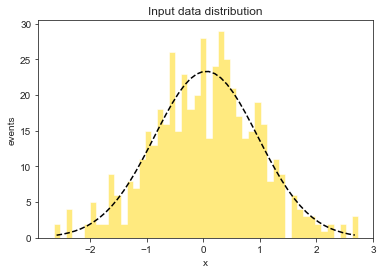

In [3]:
# Plotting results
n, bins, patches = plt.hist(data, bins=50, histtype='stepfilled', facecolor='gold', alpha=0.5)
plt.xlabel('x')
plt.ylabel('events')
plt.title('Input data distribution')

popt_gauss, pcov_gauss = curve_fit(gaussian, get_bin_centers(bins), n, p0=[1, 0, 1])
plt.plot(get_bin_centers(bins), gaussian(get_bin_centers(bins), *popt_gauss), 'k--')

plt.show()

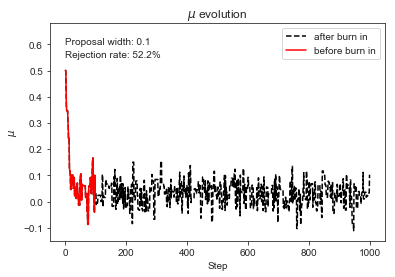

In [4]:
plt.plot(chain, 'k--', label='after burn in')
plt.plot(chain[:burnin], 'r-', label='before burn in')
plt.xlabel('Step')
plt.ylabel('$\mu$')
plt.title('$\mu$ evolution')
plt.ylim(-0.15, 0.68)
plt.text(0, 0.6, 'Proposal width: {}'.format(prop_width))
plt.text(0, 0.55, 'Rejection rate: {}%'.format(100 * rejected / len(chain)))
plt.legend()
plt.show()

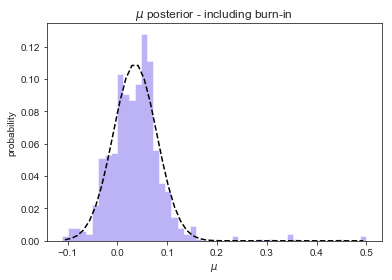

In [5]:
n, bins, patches = plt.hist(chain, bins=50, weights=np.ones_like(chain)/len(chain),
                            histtype='stepfilled', facecolor='mediumslateblue', alpha=0.5)

popt_gauss, pcov_gauss = curve_fit(gaussian, get_bin_centers(bins), n, p0=[1, 0, 1])
plt.plot(get_bin_centers(bins), gaussian(get_bin_centers(bins), *popt_gauss), 'k--')

plt.xlabel('$\mu$')
plt.ylabel('probability')
plt.title('$\mu$ posterior - including burn-in')
plt.show()

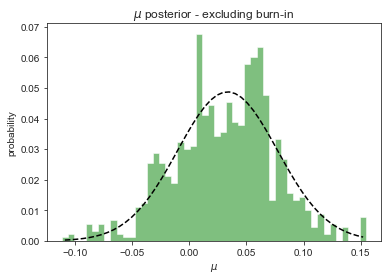

In [6]:
n, bins, patches = plt.hist(chain[burnin:], bins=50, weights=np.ones_like(chain[burnin:])/len(chain[burnin:]),
                            histtype='stepfilled', facecolor='g', alpha=0.5)

popt_gauss, pcov_gauss = curve_fit(gaussian, get_bin_centers(bins), n, p0=[1, 0, 1])
plt.plot(get_bin_centers(bins), gaussian(get_bin_centers(bins), *popt_gauss), 'k--')

plt.xlabel('$\mu$')
plt.ylabel('probability')
plt.title('$\mu$ posterior - excluding burn-in')
plt.show()